In [136]:
from shapely import wkt
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import uniform_filter, distance_transform_edt
from skimage.morphology import (
    disk, binary_opening, binary_dilation, binary_closing,
    remove_small_holes, remove_small_objects, reconstruction
)
from skimage.measure import label
from rasterio.features import rasterize
import geopandas as gpd
import math

In [169]:
# 1) Your “pre” file
base_file = (
    "/Volumes/External/TJ_SAR/02_preprocessed/02_20202025/"
    "S1A_IW_GRDH_1SDV_20240825T134455_20240825T134520_055370_06C0B3_2887_pre.tif"
)



In [170]:
def load_and_show(path, ax=None, title=None):
    """Load a single‐band GeoTIFF, autoscale to 2–98% percentiles, display image with a colorbar."""
    with rasterio.open(path) as src:
        img = src.read(1).astype(float)

    # compute 2nd and 98th percentiles for contrast stretching
    p2, p98 = np.percentile(img[np.isfinite(img)], (2, 98))

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    im = ax.imshow(img, cmap='gray_r', vmin=p2, vmax=p98)
    cbar = fig.colorbar(im, ax=ax)

    ax.set_title(title or os.path.basename(path))
    ax.axis('off')

    return ax

In [171]:
# 2) Derive the three real paths
project_root = base_file.split("/02_preprocessed")[0]
base_name    = os.path.basename(base_file).replace("_pre.tif", "")
proc_dir     = os.path.join(
    project_root,
    "03_oilClassification",
    "ContrastRatio",
    f"{base_name}_pre"
)

paths = [
    (base_file,       "Original"),
    (os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_contrast_ratio.tif"), "Contrast Ratio"),
    (os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_cumulative.tif"),      "Thresholded Contrast Ratio"),
]

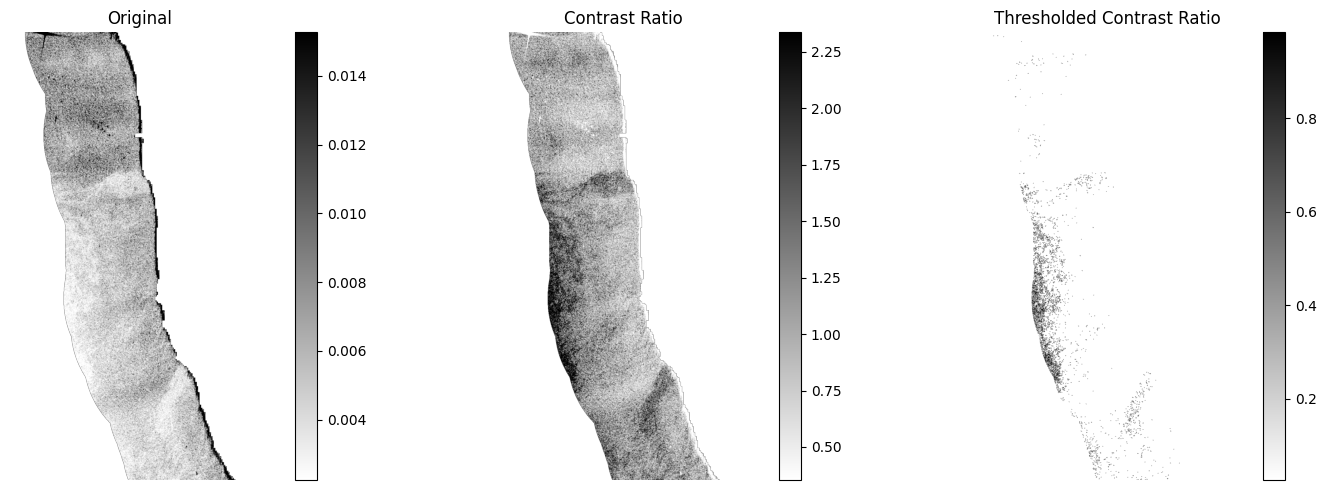

In [172]:
# 3) Plot side by side with percent‐clip normalization
fig, axes = plt.subplots(1, len(paths), figsize=(5*len(paths),5))
for ax, (p, title) in zip(axes, paths):
    load_and_show(p, ax=ax, title=title)
plt.tight_layout()

/var/folders/t1/fsg48t9j38g7vrkbkp0603fr0000gq/T/ipykernel_5379/1534233035.py:163: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pixel_pts = [rowcol(transform, geom.x, geom.y) for geom in outfalls.geometry.centroid]


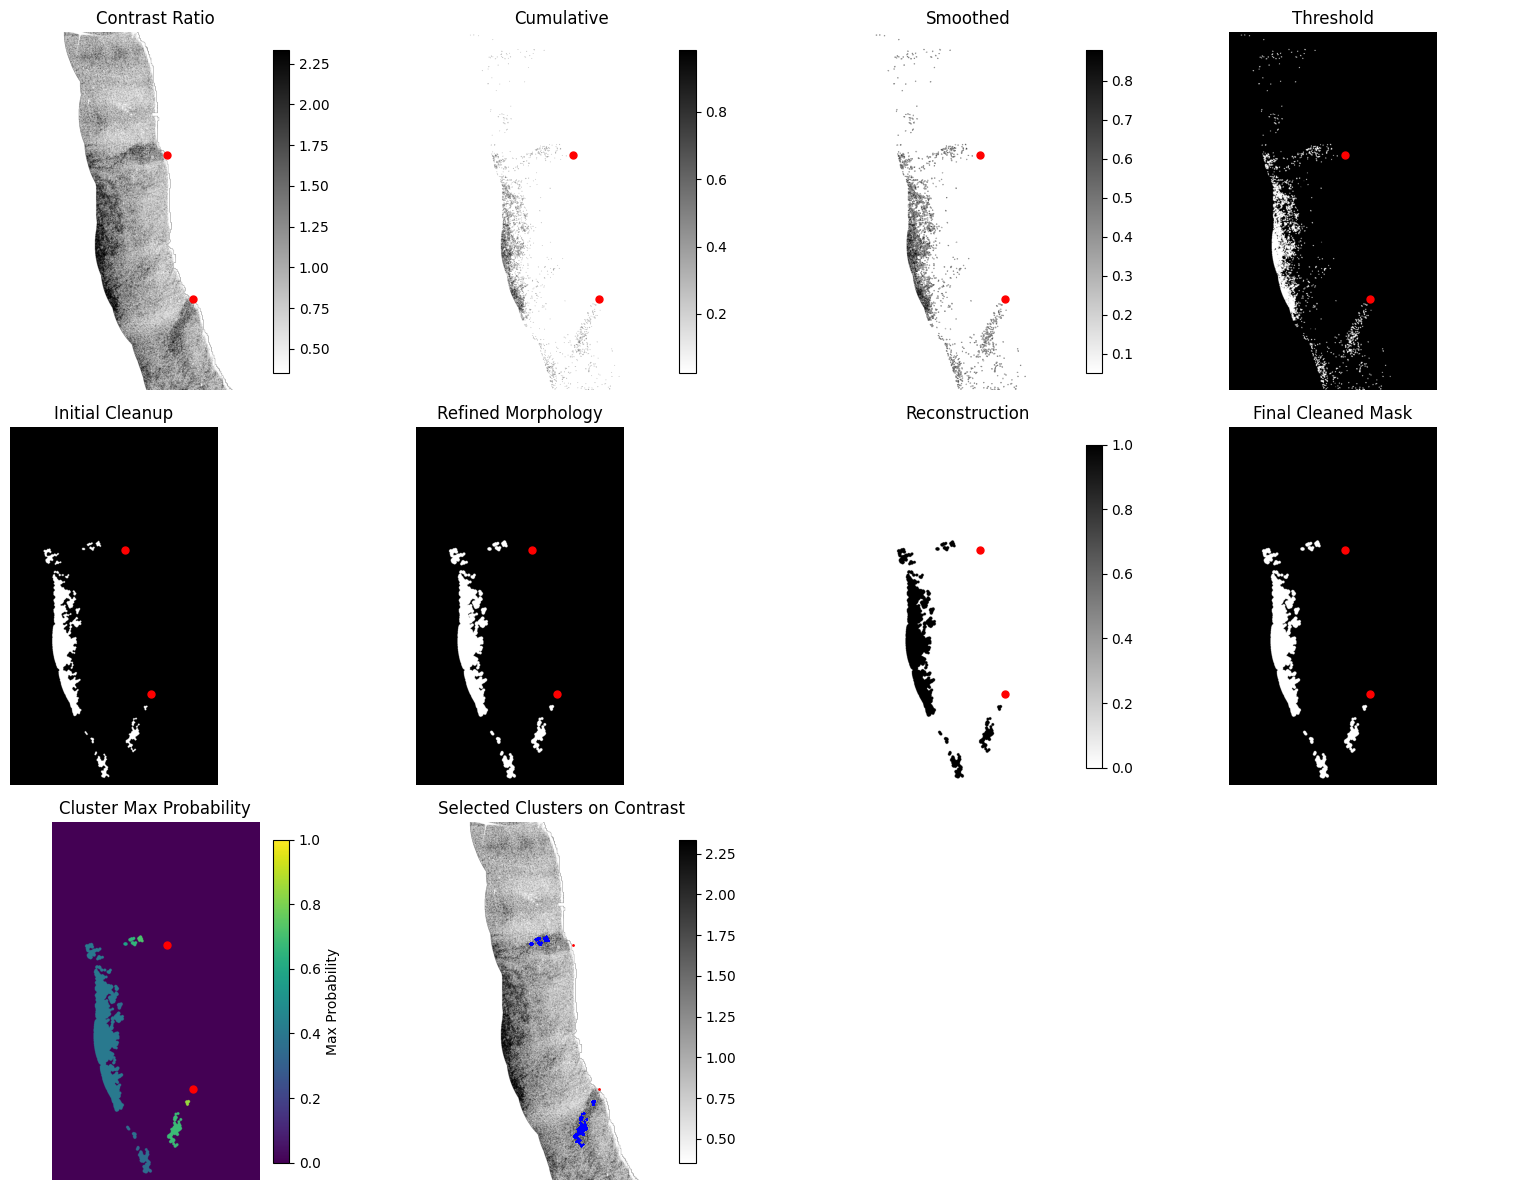

In [177]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from rasterio.features import rasterize
from rasterio.transform import rowcol
from shapely import wkt
import geopandas as gpd
from scipy.ndimage import uniform_filter, distance_transform_edt
from skimage.morphology import (
    disk,
    binary_opening,
    binary_dilation,
    binary_closing,
    remove_small_holes,
    remove_small_objects,
    reconstruction
)
from skimage.measure import label as sklabel, regionprops

# --- Utility to display arrays with 2–98% stretch and inverted grayscale ---
def load_and_show(data, ax=None):
    if isinstance(data, str):
        with rasterio.open(data) as src:
            img = src.read(1).astype(float)
    else:
        img = data.astype(float)
    valid = img[np.isfinite(img)]
    p2, p98 = np.percentile(valid, (2, 98))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure
    im = ax.imshow(img, cmap='gray_r', vmin=p2, vmax=p98)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
    return ax

# === Parameters ===
params = {
    'threshold':               0.11,
    'smooth_window':           3,
    'opening_radius':          2,
    'dilation_radius':         2,
    'closing_radius':          3,
    'hole_area_threshold':     300,
    'object_size_threshold':   100,
    'second_opening_radius':   3,
    'second_dilation_radius':  3,
    'recon_radius':            5,
    'min_cluster_area':        200,
    'decay_scale':             5000.0,
    'cluster_prob_threshold':  0.55
}

morph_params = {
    'opening':         params['opening_radius'],
    'dilation':        params['dilation_radius'],
    'closing':         params['closing_radius'],
    'second_opening':  params['second_opening_radius'],
    'second_dilation': params['second_dilation_radius'],
    'recon':           params['recon_radius']
}

# === AOI & Outfall shapefile ===
wkt_aoi = (
    'POLYGON ((-117.171936 32.379961, -117.055206 32.379961,'
    ' -117.055206 32.638218, -117.171936 32.638218, -117.171936 32.379961))'
)
aoi     = wkt.loads(wkt_aoi)
mid_lat = (aoi.bounds[1] + aoi.bounds[3]) / 2.0
outfall_shapefile = '/Volumes/External/TJ_SAR/01_data/shapefiles/Outflow.shp'

# === Paths (using your base_file variable) ===
project_root    = base_file.split("/02_preprocessed")[0]
base_name       = os.path.basename(base_file).replace("_pre.tif", "")
proc_dir        = os.path.join(
    project_root,
    "03_oilClassification",
    "ContrastRatio",
    f"{base_name}_pre"
)
contrast_path   = os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_contrast_ratio.tif")
cumulative_path = os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_cumulative.tif")

# === Load data ===
with rasterio.open(contrast_path) as src:
    contrast = src.read(1).astype(np.float32)
with rasterio.open(cumulative_path) as src:
    img       = src.read(1).astype(np.float32)
    transform = src.transform
    crs       = src.crs
    h, w      = src.height, src.width

# === 1) Low‐pass smoothing ===
valid  = (~np.isnan(img)).astype(np.float32)
filled = np.nan_to_num(img, nan=0.0)
num    = uniform_filter(filled, size=params['smooth_window'], mode='nearest')
den    = uniform_filter(valid,  size=params['smooth_window'], mode='nearest')
smooth = np.full_like(img, np.nan, dtype=np.float32)
smooth[den > 0] = num[den > 0] / den[den > 0]

# === 2) Threshold & initial cleanup ===
signal = (smooth > params['threshold']) & ~np.isnan(smooth)

def morph_sequence(mask, ops):
    for func, radius in ops:
        mask = func(mask, disk(radius))
    return mask

initial_ops = [
    (binary_opening, morph_params['opening']),
    (binary_dilation, morph_params['dilation']),
    (binary_closing, morph_params['closing']),
]
mask0 = morph_sequence(signal, initial_ops)
mask0 = remove_small_holes(mask0, area_threshold=params['hole_area_threshold'])
mask0 = remove_small_objects(mask0, min_size=params['object_size_threshold'])

# === 3) Refined morphology ===
refined_ops = [
    (binary_opening, morph_params['second_opening']),
    (binary_dilation, morph_params['second_dilation']),
]
mask_refined = morph_sequence(mask0, refined_ops)
mask_refined = remove_small_objects(mask_refined, min_size=params['min_cluster_area'])

# === 4) Reconstruction closing ===
seed       = binary_dilation(mask_refined, disk(morph_params['recon']))
mask_recon = reconstruction(seed, mask_refined, method='erosion')

# === 5) Final cleanup (cast to bool!) ===
mask_final = remove_small_objects(mask_recon.astype(bool),
                                  min_size=params['min_cluster_area'])

# === 6) Label & decay‐based selection ===
labels     = sklabel(mask_final, connectivity=2)
outfalls   = gpd.read_file(outfall_shapefile).to_crs(crs)
outfall_r  = rasterize(
    [(geom,1) for geom in outfalls.geometry],
    out_shape=(h, w), transform=transform,
    fill=0, dtype='uint8'
)
dist_px   = distance_transform_edt(outfall_r == 0)
m_per_lon = 111320 * abs(math.cos(math.radians(mid_lat)))
pix_deg   = abs(transform.a)
dist_m    = dist_px * (pix_deg * m_per_lon)
prob_full = np.exp(-dist_m / params['decay_scale'])

props = regionprops(labels, intensity_image=prob_full)
prob_map = np.zeros_like(prob_full, dtype=np.float32)
selected = []
for p in props:
    coords = tuple(zip(*p.coords))
    prob_map[coords] = p.max_intensity
    if p.max_intensity >= params['cluster_prob_threshold']:
        selected.append(p.label)
mask_selected = np.isin(labels, selected)

# compute pixel centers for outfall dots
pixel_pts = [rowcol(transform, geom.x, geom.y) for geom in outfalls.geometry.centroid]
dot_coords = [(col, row) for row, col in pixel_pts]

# === 7) Plot panels including final Selected Clusters on contrast ===
steps = [
    (contrast,      "Contrast Ratio"),
    (img,           "Cumulative"),
    (smooth,        "Smoothed"),
    (signal,        "Threshold"),
    (mask0,         "Initial Cleanup"),
    (mask_refined,  "Refined Morphology"),
    (mask_recon,    "Reconstruction"),
    (mask_final,    "Final Cleaned Mask"),
    (prob_map,      "Cluster Max Probability"),
]

cols = 4
rows = (len(steps) + 1 + cols - 1) // cols  # +1 for final panel
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

# plot standard steps
for i, (data, title) in enumerate(steps):
    ax = axes[i]
    if title == "Cluster Max Probability":
        im = ax.imshow(data, vmin=0, vmax=1)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04,
                     label='Max Probability')
    else:
        if isinstance(data, np.ndarray) and data.dtype == bool:
            ax.imshow(data, cmap='gray', vmin=0, vmax=1)
        else:
            load_and_show(data, ax=ax)
    for x_dot, y_dot in dot_coords:
        ax.plot(x_dot, y_dot, 'ro', markersize=5)
    ax.set_title(title)
    ax.axis('off')

# final "Selected Clusters on Contrast" panel
ax = axes[len(steps)]
# background: stretched contrast
load_and_show(contrast, ax=ax)
# overlay: mask_selected as solid red (0 transparent, 1 red)
cmap = mcolors.ListedColormap(['none', 'blue'])
ax.imshow(mask_selected, cmap=cmap, interpolation='none')
# red outfall dots
for x_dot, y_dot in dot_coords:
    ax.plot(x_dot, y_dot, 'ro', markersize=1)
ax.set_title("Selected Clusters on Contrast")
ax.axis('off')

# turn off any extra axes
for extra_ax in axes[len(steps)+1:]:
    extra_ax.axis('off')

plt.tight_layout()
plt.show()


In [179]:
import os
import glob
import math

import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import rowcol
from scipy.ndimage import uniform_filter, distance_transform_edt
from skimage.morphology import (
    disk, binary_opening, binary_dilation, binary_closing,
    remove_small_holes, remove_small_objects, reconstruction
)
from skimage.measure import label as sklabel, regionprops
from shapely import wkt
import geopandas as gpd

# === PARAMETERS ===
params = {
    'threshold':               0.11,
    'smooth_window':           3,
    'opening_radius':          2,
    'dilation_radius':         2,
    'closing_radius':          3,
    'hole_area_threshold':     300,
    'object_size_threshold':   100,
    'second_opening_radius':   3,
    'second_dilation_radius':  3,
    'recon_radius':            5,
    'min_cluster_area':        200,
    'decay_scale':             5000.0,
    'cluster_prob_threshold':  0.55
}

morph_params = {
    'opening':         params['opening_radius'],
    'dilation':        params['dilation_radius'],
    'closing':         params['closing_radius'],
    'second_opening':  params['second_opening_radius'],
    'second_dilation': params['second_dilation_radius'],
    'recon':           params['recon_radius']
}

# AOI for mid-latitude distance calculation
wkt_aoi = (
    'POLYGON ((-117.171936 32.379961, -117.055206 32.379961,'
    ' -117.055206 32.638218, -117.171936 32.638218, -117.171936 32.379961))'
)
aoi     = wkt.loads(wkt_aoi)
mid_lat = (aoi.bounds[1] + aoi.bounds[3]) / 2.0

# === PATHS ===
INPUT_DIR   = "/Volumes/External/TJ_SAR/02_preprocessed/02_20202025/"
PROJECT_ROOT = INPUT_DIR.split("/02_preprocessed")[0]
OUT_DIR     = "/Volumes/External/TJ_SAR/04_iseg/version2seg/"
OUTFALL_SHP = "/Volumes/External/TJ_SAR/01_data/shapefiles/Outflow.shp"

os.makedirs(OUT_DIR, exist_ok=True)

# Load outfalls once
outfalls = gpd.read_file(OUTFALL_SHP)

def process_file(pre_tif_path):
    base_name = os.path.basename(pre_tif_path).replace("_pre.tif", "")
    proc_dir = os.path.join(
        PROJECT_ROOT,
        "03_oilClassification",
        "ContrastRatio",
        f"{base_name}_pre"
    )
    contrast_path   = os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_contrast_ratio.tif")
    cumulative_path = os.path.join(proc_dir, f"{base_name}_pre_JPL0.4_VVDR_cumulative.tif")

    # --- load imagery ---
    with rasterio.open(contrast_path) as src:
        contrast = src.read(1).astype(np.float32)
    with rasterio.open(cumulative_path) as src:
        img       = src.read(1).astype(np.float32)
        transform = src.transform
        crs       = src.crs
        h, w      = src.height, src.width

    # 1) Low‐pass smoothing
    valid  = (~np.isnan(img)).astype(np.float32)
    filled = np.nan_to_num(img, nan=0.0)
    num    = uniform_filter(filled, size=params['smooth_window'], mode='nearest')
    den    = uniform_filter(valid,  size=params['smooth_window'], mode='nearest')
    smooth = np.full_like(img, np.nan, dtype=np.float32)
    smooth[den > 0] = num[den > 0] / den[den > 0]

    # 2) Threshold & initial cleanup
    signal = (smooth > params['threshold']) & ~np.isnan(smooth)
    def morph_sequence(mask, ops):
        for func, radius in ops:
            mask = func(mask, disk(radius))
        return mask

    initial_ops = [
        (binary_opening, morph_params['opening']),
        (binary_dilation, morph_params['dilation']),
        (binary_closing, morph_params['closing']),
    ]
    mask0 = morph_sequence(signal, initial_ops)
    mask0 = remove_small_holes(mask0, area_threshold=params['hole_area_threshold'])
    mask0 = remove_small_objects(mask0, min_size=params['object_size_threshold'])

    # 3) Refined morphology
    refined_ops = [
        (binary_opening, morph_params['second_opening']),
        (binary_dilation, morph_params['second_dilation']),
    ]
    mask_refined = morph_sequence(mask0, refined_ops)
    mask_refined = remove_small_objects(mask_refined, min_size=params['min_cluster_area'])

    # 4) Reconstruction closing
    seed       = binary_dilation(mask_refined, disk(morph_params['recon']))
    mask_recon = reconstruction(seed, mask_refined, method='erosion')

    # 5) Final cleanup
    mask_final = remove_small_objects(mask_recon.astype(bool),
                                      min_size=params['min_cluster_area'])

    # 6) Label & decay‐based selection
    labels   = sklabel(mask_final, connectivity=2)
    outfall_r = rasterize(
        [(geom,1) for geom in outfalls.to_crs(crs).geometry],
        out_shape=(h, w), transform=transform,
        fill=0, dtype='uint8'
    )
    dist_px   = distance_transform_edt(outfall_r == 0)
    m_per_lon = 111_320 * abs(math.cos(math.radians(mid_lat)))
    pix_deg   = abs(transform.a)
    dist_m    = dist_px * (pix_deg * m_per_lon)
    prob_full = np.exp(-dist_m / params['decay_scale'])

    props     = regionprops(labels, intensity_image=prob_full)
    selected  = [p.label for p in props if p.max_intensity >= params['cluster_prob_threshold']]
    mask_selected = np.isin(labels, selected)

    return mask_selected, crs, transform

# === BATCH PROCESS ===
for pre_tif in glob.glob(os.path.join(INPUT_DIR, "*_pre.tif")):
    mask_sel, crs, transform = process_file(pre_tif)

    out_name = os.path.basename(pre_tif).replace("_pre.tif", "_mask_selected.tif")
    out_path = os.path.join(OUT_DIR, out_name)

    # write mask_selected as uint8 (0/1)
    h, w = mask_sel.shape
    with rasterio.open(
        out_path, 'w',
        driver='GTiff',
        height=h,
        width=w,
        count=1,
        dtype=rasterio.uint8,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(mask_sel.astype(rasterio.uint8), 1)

    print(f"Wrote: {out_path}")


Wrote: /Volumes/External/TJ_SAR/04_iseg/version2seg/S1A_IW_GRDH_1SDV_20250621T134447_20250621T134512_059745_076B58_9374_mask_selected.tif


RasterioIOError: /Volumes/External/TJ_SAR/03_oilClassification/ContrastRatio/S1C_IW_GRDH_1SDV_20250615T134348_20250615T134413_002794_005BD8_CB3F_pre/S1C_IW_GRDH_1SDV_20250615T134348_20250615T134413_002794_005BD8_CB3F_pre_JPL0.4_VVDR_contrast_ratio.tif: No such file or directory

In [180]:
import os
import math
import numpy as np
import rasterio
from rasterio.features import rasterize
from scipy.ndimage import uniform_filter, distance_transform_edt
from skimage.morphology import (
    disk, binary_opening, binary_dilation, binary_closing,
    remove_small_holes, remove_small_objects, reconstruction
)
from skimage.measure import label as sklabel, regionprops
from shapely import wkt
import geopandas as gpd

# === PARAMETERS ===
params = {
    'threshold':               0.11,
    'smooth_window':           3,
    'opening_radius':          2,
    'dilation_radius':         2,
    'closing_radius':          3,
    'hole_area_threshold':     300,
    'object_size_threshold':   100,
    'second_opening_radius':   3,
    'second_dilation_radius':  3,
    'recon_radius':            5,
    'min_cluster_area':        200,
    'decay_scale':             5000.0,
    'cluster_prob_threshold':  0.55
}
morph = {
    'opening':        params['opening_radius'],
    'dilation':       params['dilation_radius'],
    'closing':        params['closing_radius'],
    'second_opening': params['second_opening_radius'],
    'second_dilation':params['second_dilation_radius'],
    'recon':          params['recon_radius']
}

# AOI for distance calc
wkt_aoi = (
    'POLYGON ((-117.171936 32.379961, -117.055206 32.379961,'
    ' -117.055206 32.638218, -117.171936 32.638218, -117.171936 32.379961))'
)
aoi     = wkt.loads(wkt_aoi)
mid_lat = (aoi.bounds[1] + aoi.bounds[3]) / 2.0

# === PATHS ===
PROJECT_ROOT  = "/Volumes/External/TJ_SAR"
CR_DIR        = os.path.join(PROJECT_ROOT, "03_oilClassification", "ContrastRatio")
OUT_DIR       = os.path.join(PROJECT_ROOT, "04_iseg", "version2seg")
OUTFALL_SHP   = os.path.join(PROJECT_ROOT, "01_data", "shapefiles", "Outflow.shp")

os.makedirs(OUT_DIR, exist_ok=True)
outfalls = gpd.read_file(OUTFALL_SHP)

def process_scene(scene_dir):
    """Given a ContrastRatio/<scene>_pre folder, find the two tifs and run segmentation."""
    # find contrast‐ratio file
    for fn in os.listdir(scene_dir):
        if fn.endswith("_contrast_ratio.tif"):
            contrast_path = os.path.join(scene_dir, fn)
            base = fn.replace("_pre_JPL0.4_VVDR_contrast_ratio.tif", "")
            break
    else:
        print(f"⚠️ No contrast_ratio in {scene_dir}, skipping.")
        return

    cum_fn = f"{base}_pre_JPL0.4_VVDR_cumulative.tif"
    cum_path = os.path.join(scene_dir, cum_fn)
    if not os.path.exists(cum_path):
        print(f"⚠️ No cumulative file {cum_fn} in {scene_dir}, skipping.")
        return

    # load rasters & metadata
    with rasterio.open(contrast_path) as src:
        contrast = src.read(1).astype(np.float32)
    with rasterio.open(cum_path) as src:
        img       = src.read(1).astype(np.float32)
        transform = src.transform
        crs       = src.crs
        h, w      = src.height, src.width

    # 1) smoothing
    valid  = (~np.isnan(img)).astype(np.float32)
    filled = np.nan_to_num(img, nan=0.0)
    num    = uniform_filter(filled, size=params['smooth_window'], mode='nearest')
    den    = uniform_filter(valid,  size=params['smooth_window'], mode='nearest')
    smooth = np.full_like(img, np.nan, np.float32)
    smooth[den > 0] = num[den > 0] / den[den > 0]

    # 2) threshold + cleanup
    signal = (smooth > params['threshold']) & ~np.isnan(smooth)
    def morph_seq(m, ops):
        for f, r in ops:
            m = f(m, disk(r))
        return m

    mask0 = morph_seq(signal, [
        (binary_opening, morph['opening']),
        (binary_dilation, morph['dilation']),
        (binary_closing, morph['closing']),
    ])
    mask0 = remove_small_holes(mask0, area_threshold=params['hole_area_threshold'])
    mask0 = remove_small_objects(mask0, min_size=params['object_size_threshold'])

    # 3) refined
    mask_r = morph_seq(mask0, [
        (binary_opening, morph['second_opening']),
        (binary_dilation, morph['second_dilation']),
    ])
    mask_r = remove_small_objects(mask_r, min_size=params['min_cluster_area'])

    # 4) reconstruction
    seed    = binary_dilation(mask_r, disk(morph['recon']))
    mask_re = reconstruction(seed, mask_r, method='erosion')

    # 5) final cleanup
    mask_f = remove_small_objects(mask_re.astype(bool),
                                  min_size=params['min_cluster_area'])

    # 6) labeling + decay
    labels   = sklabel(mask_f, connectivity=2)
    out_rast = rasterize(
        [(g,1) for g in outfalls.to_crs(crs).geometry],
        out_shape=(h,w), transform=transform, fill=0, dtype='uint8'
    )
    dist_px = distance_transform_edt(out_rast==0)
    m_per_lon = 111320 * abs(math.cos(math.radians(mid_lat)))
    pix_deg   = abs(transform.a)
    dist_m    = dist_px * pix_deg * m_per_lon
    prob      = np.exp(-dist_m / params['decay_scale'])

    sel = [p.label for p in regionprops(labels, intensity_image=prob)
           if p.max_intensity >= params['cluster_prob_threshold']]
    mask_sel = np.isin(labels, sel)

    # write out
    out_name = f"{base}_mask_selected.tif"
    out_path = os.path.join(OUT_DIR, out_name)
    with rasterio.open(
        out_path, 'w',
        driver='GTiff', height=h, width=w, count=1,
        dtype=rasterio.uint8, crs=crs, transform=transform
    ) as dst:
        dst.write(mask_sel.astype(rasterio.uint8), 1)

    print(f"✅ {base}: wrote {out_name}")

# === RUN THROUGH ALL SCENES ===
for scene in os.listdir(CR_DIR):
    scene_dir = os.path.join(CR_DIR, scene)
    if os.path.isdir(scene_dir) and scene.endswith("_pre"):
        print(f"Processing scene {scene} …")
        process_scene(scene_dir)


Processing scene S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre …
✅ S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E: wrote S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_mask_selected.tif
Processing scene S1A_IW_GRDH_1SDV_20221121T135317_20221121T135342_045993_058110_4619_pre …
✅ S1A_IW_GRDH_1SDV_20221121T135317_20221121T135342_045993_058110_4619: wrote S1A_IW_GRDH_1SDV_20221121T135317_20221121T135342_045993_058110_4619_mask_selected.tif
Processing scene S1A_IW_GRDH_1SDV_20221128T134454_20221128T134519_046095_05847D_4A73_pre …
✅ S1A_IW_GRDH_1SDV_20221128T134454_20221128T134519_046095_05847D_4A73: wrote S1A_IW_GRDH_1SDV_20221128T134454_20221128T134519_046095_05847D_4A73_mask_selected.tif
Processing scene S1A_IW_GRDH_1SDV_20221203T015015_20221203T015044_046161_0586BC_72DC_pre …
✅ S1A_IW_GRDH_1SDV_20221203T015015_20221203T015044_046161_0586BC_72DC: wrote S1A_IW_GRDH_1SDV_20221203T015015_20221203T015044_046161_0586BC_72DC_ma

In [ ]:
parameters
preprocessed
output from autoSAR _contrastratio
_cumulative is that thresholded,

In [1]:
FIRST
compare contrast ratio to _cumulative and see if data is being thresholded out

NameError: name 'FIRST' is not defined

In [ ]:
#original_root = '/Volumes/External/TJ_SAR/02_preprocessed/02_20202025/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre.tif'
#auto_SAR = /Volumes/External/TJ_SAR/03_oilClassification/ContrastRatio/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre_JPL0.4_VVDR_contrast_ratio.tif /Volumes/External/TJ_SAR/03_oilClassification/ContrastRatio/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre_JPL0.4_VVDR_cumulative.tif
#mask_root = '/Volumes/External/TJ_SAR/04_iseg/20202025/S1A_IW_GRDH_1SDV_20221121T015015_20221121T015044_045986_0580C5_7D6E_pre_JPL0.4_VVDR_cumulative_prob.tif'



In [ ]:
SECOND

this uses the THRESHOLDED from cumulative, maybe we do it on contrast ratio and then threshold later???

1)
    # Low-pass filter
    valid_mask = (~np.isnan(image)).astype(np.float32)
    image_filled = np.nan_to_num(image, nan=0.0)
    numerator = uniform_filter(image_filled, size=3, mode='nearest')
    denominator = uniform_filter(valid_mask, size=3, mode='nearest')
    smoothed = np.full_like(image, np.nan, dtype=np.float32)
    nonzero_mask = denominator > 0
    smoothed[nonzero_mask] = numerator[nonzero_mask] / denominator[nonzero_mask]

2)
    # Threshold and cleanup
    signal_mask = (smoothed > threshold_value) & ~np.isnan(smoothed)
    clean_mask = binary_opening(signal_mask, disk(2))
    clean_mask = binary_closing(clean_mask, disk(3))
    clean_mask = remove_small_holes(clean_mask, area_threshold=300)
    clean_mask = remove_small_objects(clean_mask, min_size=100)
    expanded_mask = binary_dilation(clean_mask, disk(2))


In [ ]:
THIRD step

add in proximity probability and then threshold....
    # 4. Rasterize outfall points and compute distance transform
    outfalls = gpd.read_file(outfall_shapefile).to_crs(crs)
    outfall_r = rasterize(
        [(geom, 1) for geom in outfalls.geometry],
        out_shape=(h, w), transform=transform,
        fill=0, dtype='uint8'
    )
    dist_px = distance_transform_edt(outfall_r == 0)
    mid_lat = (wkt.loads(wkt_aoi).bounds[1] + wkt.loads(wkt_aoi).bounds[3]) / 2.0
    m_per_lon = 111320 * abs(math.cos(math.radians(mid_lat)))
    pix_deg   = abs(transform.a)
    dist_m    = dist_px * (pix_deg * m_per_lon)

    # 5. Compute exponential decay probability across image
    prob_full = np.exp(-dist_m / decay_scale)

    # 6. Label clusters and assign max probability per cluster
    labels, n_clusters = label(mask)
    prob_map = np.zeros_like(prob_full, dtype=np.float32)
    selected_labels = []
    for c in range(1, n_clusters + 1):
        region = (labels == c)
        if not np.any(region):
            continue
        max_p = prob_full[region].max()  # highest decay probability in cluster
        # assign max probability for all clusters
        prob_map[region] = max_p
        # threshold only for selection mask
        if max_p >= cluster_prob_threshold:
            selected_labels.append(c)
